In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
import os
import cv2

In [22]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [23]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-disease-dataset/subset(96%)",
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 4925 files belonging to 13 classes.


In [24]:
classes = data.class_names
print(f"Number of Classes: {len(classes)}\n")
print(f"Classes: {classes}")

Number of Classes: 13

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [25]:
len(data)

154

In [26]:
for img_batch, label_batch in data.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 5  2  9  3  3  1  4  1 10  6  4 12 11  6  3  1  6  0  8  4 10  8  2  8
  4  6  5  7  6  7 11  7]


In [27]:
for img_batch, label_batch in data.take(1):
    print(img_batch[0].shape)

(256, 256, 3)


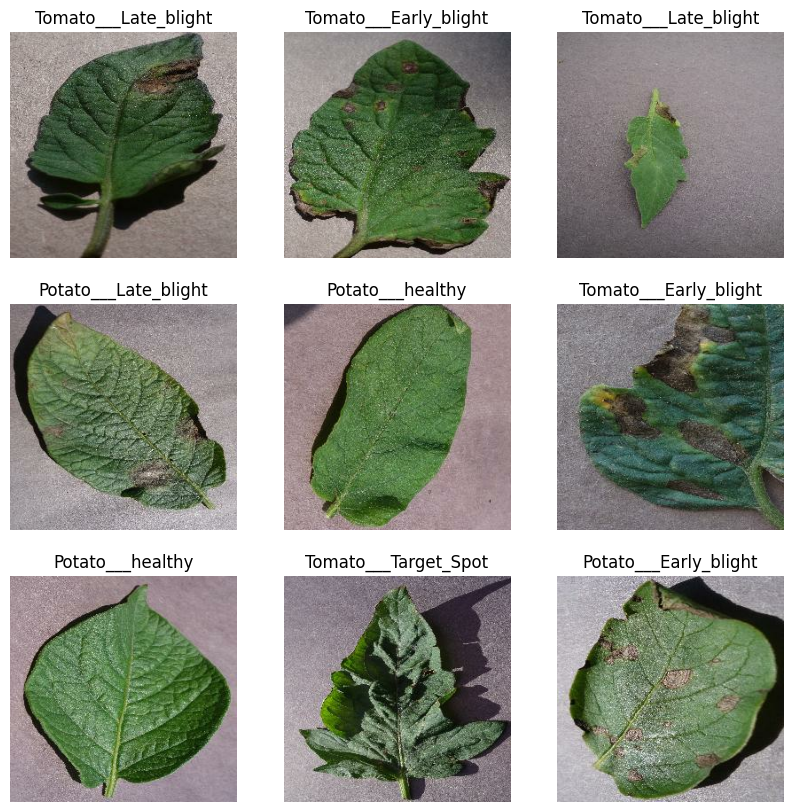

In [28]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        plt.title(classes[label_batch[i].numpy()])
        plt.axis('off')

In [29]:
def prepare_datasets(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2000):
    size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size)

    train_size = int(size * train_split)
    val_size = int(size * val_split)

    train_data = data.take(train_size)
    rem_data = data.skip(train_size)
    val_data = rem_data.take(val_size)
    test_data = rem_data.skip(val_size)

    return train_data, val_data, test_data

In [30]:
train_data, val_data, test_data = prepare_datasets(data)
print(f"Dataset sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Dataset sizes -> Train: 123, Val: 15, Test: 16


In [31]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
preprocess_image = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
        tf.keras.layers.Rescaling(1./255)
    ]
)

In [33]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.3),
        layers.GaussianNoise(0.2),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
    ]
)

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = len(classes)

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

/tmp/ipykernel_23/2233581475.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')


In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy', 
    patience=5,              
    restore_best_weights=True,  
    min_delta=0.001,         
    verbose=1                 
)

In [37]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 234ms/step - accuracy: 0.0861 - loss: 6.1160 - val_accuracy: 0.1396 - val_loss: 5.7101
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.1165 - loss: 5.7028 - val_accuracy: 0.1354 - val_loss: 5.6682
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.1874 - loss: 5.5594 - val_accuracy: 0.1312 - val_loss: 5.6282
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.2159 - loss: 5.4504 - val_accuracy: 0.1271 - val_loss: 5.5893
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.3109 - loss: 5.2908 - val_accuracy: 0.1333 - val_loss: 5.5407
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.3522 - loss: 5.1500 - val_accuracy: 0.1688 - val_loss: 5.4782
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.4121 - loss: 4.9749 - val_accuracy: 0.1917 - val_loss: 5.3983
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.4684 - loss: 4.7838 - val_ac

In [38]:
model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9104 - loss: 2.7499


[2.732485055923462, 0.916015625]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


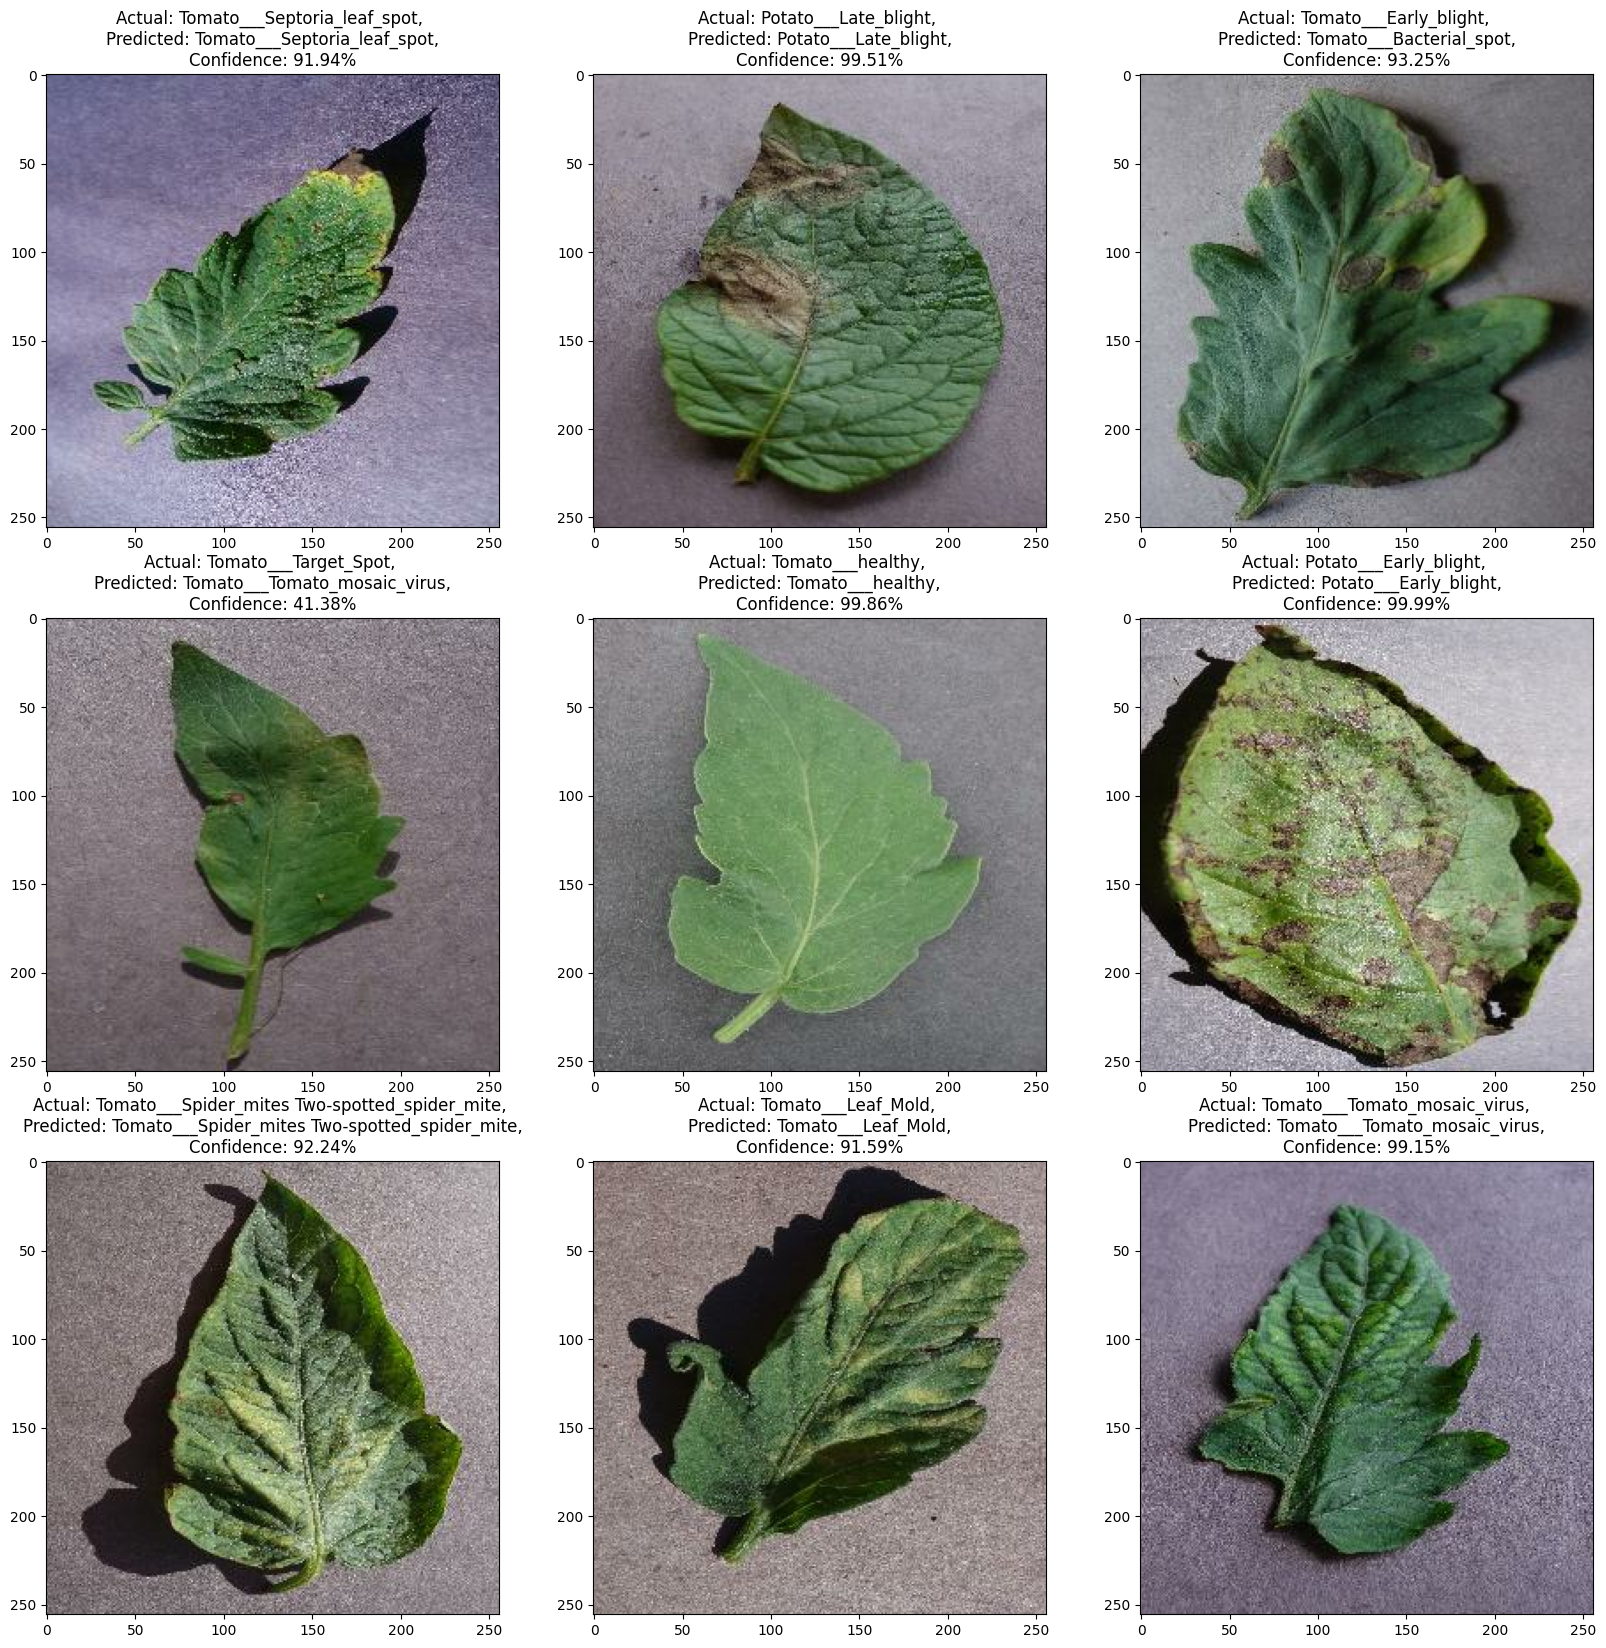

In [39]:
def predict(model, img):
    img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis=0)
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(20, 20))
for img_batch, label_batch in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        predicted_class, confidence = predict(model, img_batch[i])
        actual_class = classes[label_batch[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\nConfidence: {confidence}%")

In [40]:
def analyze_predictions(model, dataset):
    prediction_counts = {cls: 0 for cls in classes}
    for img_batch, _ in dataset.take(len(dataset)):
        preds = model.predict(img_batch)
        for pred in preds:
            predicted_class = classes[np.argmax(pred)]
            prediction_counts[predicted_class] += 1
    return prediction_counts

print("Class Prediction Counts:")
print(analyze_predictions(model, test_data))

Class Prediction Counts:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'Potato___Early_blight': 51, 'Potato___Late_blight': 39, 'Potato___healthy': 23, 'Tomato___Bacterial_spot': 48, 'Tomato___Early_blight': 53, 'Tomato___Late_blight': 54, 'Tomato___Leaf_Mold': 44, 'Tomato___Septoria_leaf_spot': 38, 'Tomato___Spider_mites Two-spotted_spider_mite': 30, 'Tomato___Target_Spot': 37, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 26, 'Tomato___T

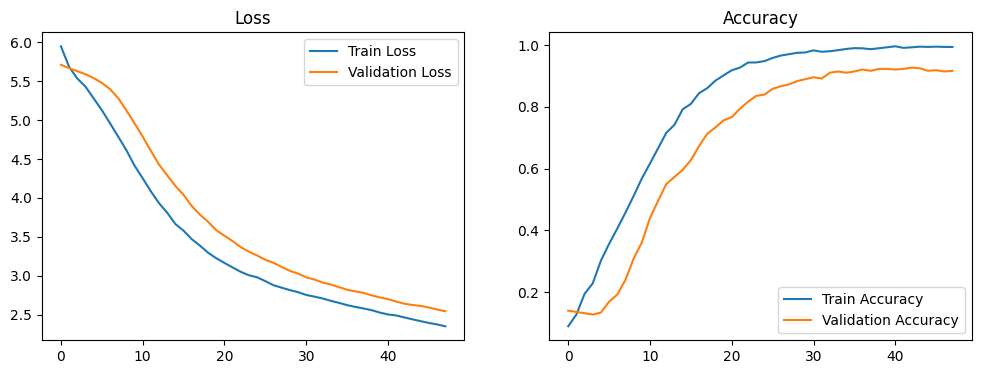

In [41]:
def plot_training(history):
    plt.figure(figsize=(12, 4))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_training(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


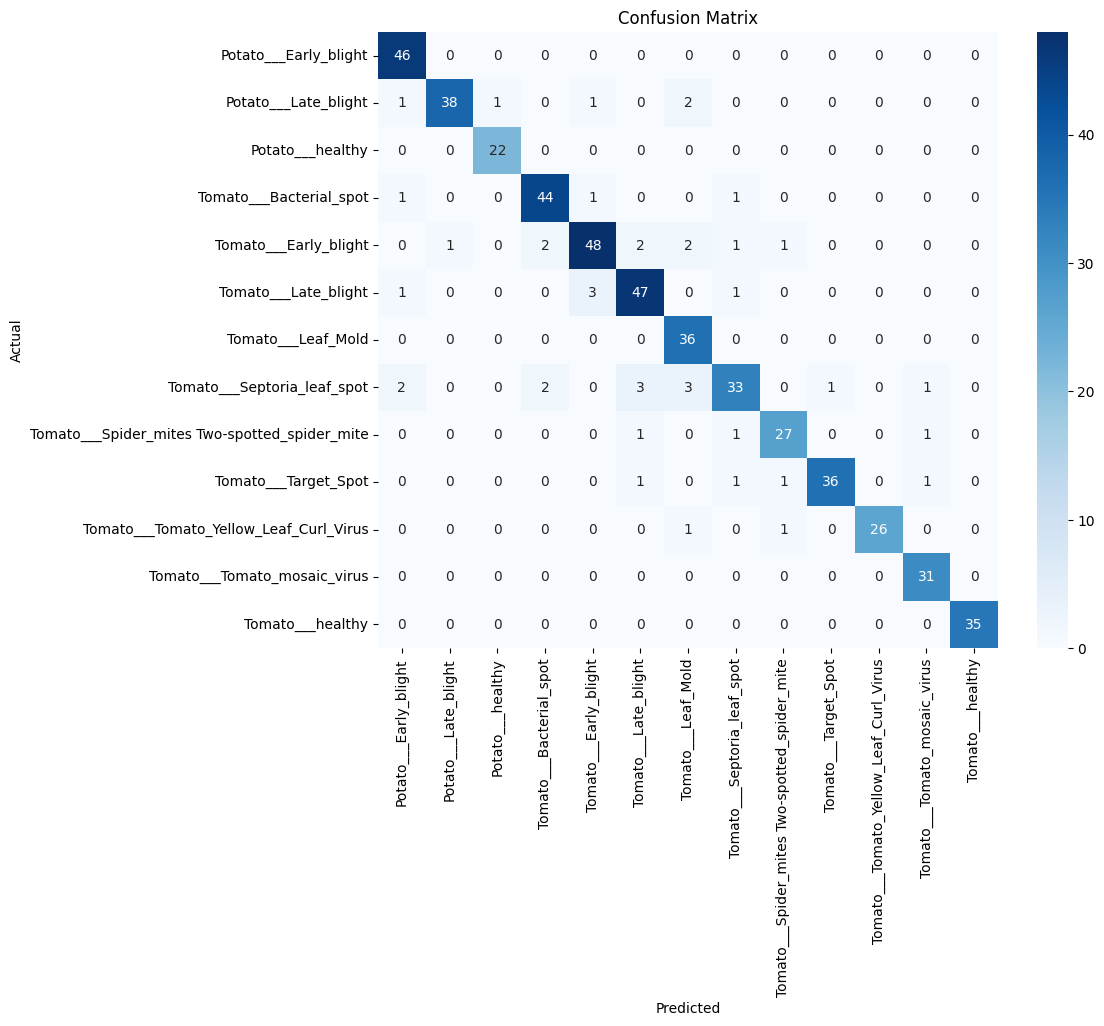

In [42]:
def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []
    for img_batch, label_batch in dataset:
        preds = model.predict(img_batch)
        y_true.extend(label_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_data, classes)


In [43]:
model_version = 1
model.save(f"/kaggle/working/model_v{model_version}.h5")